In [1]:
import numpy as np
import pickle
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch as torch
from scikitplot.decomposition import plot_pca_2d_projection, plot_pca_component_variance
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
data_path = "/om2/user/jackking/modular_transformers/scripts/attention_interpretability"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datasource = "ud"
sentence_length = 10
datatype = f"{datasource}/{sentence_length}_word"
model_name = "gpt2-xl"
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

curvatures = pickle.load(open(f"{data_path}/data/{datatype}/{model_name}_curvatures.pkl", "rb"))
sentences = pickle.load(open(f"{data_path}/data/{datatype}/sentences.pkl", "rb"))
#num_samples, num_layers+1, context_len, embedding_dim
activations = pickle.load(open(f"{data_path}/data/{datatype}/{model_name}_activations.pkl", "rb"))
activations = np.stack([np.stack(sublist) for sublist in activations])

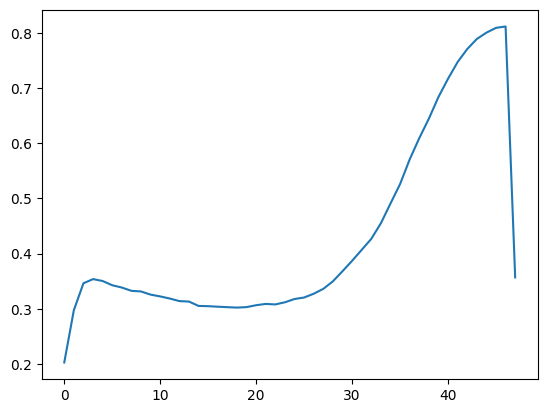

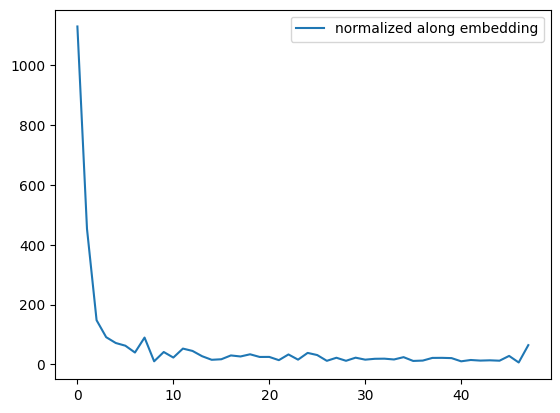

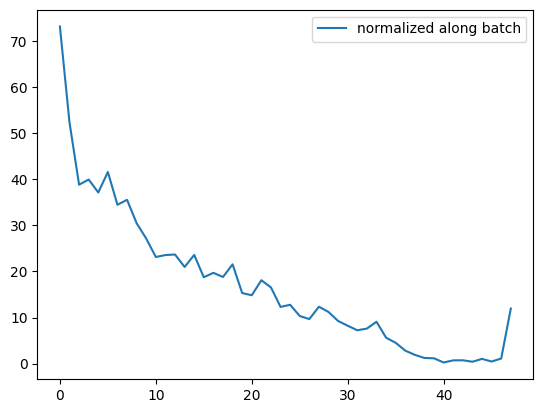

In [158]:
# for every layer, learn a linear transformation that maps the activations to the next layer's activations
# if the representation at one layer can be linearly transformed to the next layer, then the representation should be straighter

def calculate_kl(x, y, axis):
    tensor1 = x / x.sum(axis=axis, keepdims=True)
    tensor2 = y / y.sum(axis=axis, keepdims=True)
    #remove zeros
    tensor1 = np.clip(tensor1, 1e-12, 1)
    tensor2 = np.clip(tensor2, 1e-12, 1)
    kl_divergence = np.sum(tensor1 * (np.log(tensor1) - np.log(tensor2)), axis=axis)
    return kl_divergence

def learn_linear_transformations(activations, curvatures):
    num_layers = activations.shape[1]

    num_samples = 300
    first_token = 1

    accuracies = []
    r2 = []
    divergences_normalized_along_embd = []
    divergences_normalized_along_batch = []
    predxcurve = np.zeros((num_layers-1, activations.shape[2]))
    distance_to_final = np.zeros((num_layers-1, activations.shape[2], num_samples - int(num_samples * 0.8)))
    distance_to_final_corr = np.zeros((num_layers-1, activations.shape[2]))

    for layer in range(num_layers-1):

        # W matrix for each token -------

        X = activations[:num_samples, layer, :, :]
        Y = activations[:num_samples, layer+1, :, :]

        layer_accuracies = []
        layer_r2 = []
        ldnae = []
        ldnab = []

        offset = 2

        for token_num in range(5, X.shape[1]):
            split = int(X.shape[0] * 0.8)
            x_train = X[:split, token_num, :]
            y_train = Y[:split, token_num, :]
            x_test = X[split:, token_num, :]
            y_test = Y[split:, token_num, :]
            # #normalize everything

            # x_train = X[:split, token_num-offset:token_num+1, :].reshape(-1, (offset+1)*1600)
            # x_test = X[split:, token_num-offset:token_num+1, :].reshape(-1, (offset+1)*1600)

            
            # x_train = x_train / np.linalg.norm(x_train, axis=1, keepdims=True)
            # y_train = y_train / np.linalg.norm(y_train, axis=1, keepdims=True)
            # x_test = x_test / np.linalg.norm(x_test, axis=1, keepdims=True)
            # y_test = y_test / np.linalg.norm(y_test, axis=1, keepdims=True)

            w = np.linalg.lstsq(x_train, y_train, rcond=None)[0]
            Y_pred = np.dot(x_test, w)
            acc = (y_test - Y_pred)**2
            layer_accuracies.append(np.mean(acc))
            acc = np.mean(acc, axis=1)

            #correlate with curvature
            curvature = np.array(curvatures["all_layer_curve_all"])[split:num_samples, layer, token_num-3]#.mean(axis=-1)
            corr = stats.pearsonr(curvature, acc)
            predxcurve[layer, token_num] = corr[0]

            #calculate distance to final representation
            final_representation = activations[split:num_samples, -1, token_num, :]
            final_representation = final_representation / np.linalg.norm(final_representation, axis=1, keepdims=True)
            y_test_normalized = y_test / np.linalg.norm(y_test, axis=1, keepdims=True)
            distance = np.linalg.norm(final_representation - y_test_normalized, axis=1)
            corr = stats.pearsonr(curvature, distance)
            distance_to_final[layer, token_num] = distance
            distance_to_final_corr[layer, token_num] = corr[0]

            #calculate r^2
            y_mean = np.mean(y_test, axis=0)
            total_sum_of_squares = np.sum((y_test - y_mean)**2)
            residual_sum_of_squares = np.sum((y_test - Y_pred)**2)
            layer_r2.append(1 - residual_sum_of_squares / total_sum_of_squares)

            x = X[:, token_num, :]
            y = Y[:, token_num, :]
            ldnae.append(calculate_kl(x, y, axis=1))
            ldnab.append(calculate_kl(x, y, axis=0))
        
        accuracies.append(np.mean(layer_accuracies))
        r2.append(np.mean(layer_r2))
        divergences_normalized_along_embd.append(np.mean(ldnae))
        divergences_normalized_along_batch.append(np.mean(ldnab))


    return accuracies, r2, divergences_normalized_along_embd, divergences_normalized_along_batch, predxcurve, distance_to_final, distance_to_final_corr

accuracies, r2, divergences_normalized_along_embd, divergences_normalized_along_batch, predxcurve, distance_to_final, distance_to_final_corr = learn_linear_transformations(activations, curvatures)

# plt.plot(accuracies)
# plt.show()

plt.plot(r2)
plt.show()

#this is the KL divergence for each sample (comparing sample at layer i to sample at layer i+1)
plt.plot(divergences_normalized_along_embd, label="normalized along embedding")
plt.legend()
plt.show()

#this is the KL divergence for each dimension of the embedding (comparing dim at layer i to dim at layer i+1 over samples)
plt.plot(divergences_normalized_along_batch, label="normalized along batch")
plt.legend()
plt.show()

#next steps
#correlate context used for prediction with prediction ability
#do the attention pattern stuff
#correlate curvature with logit

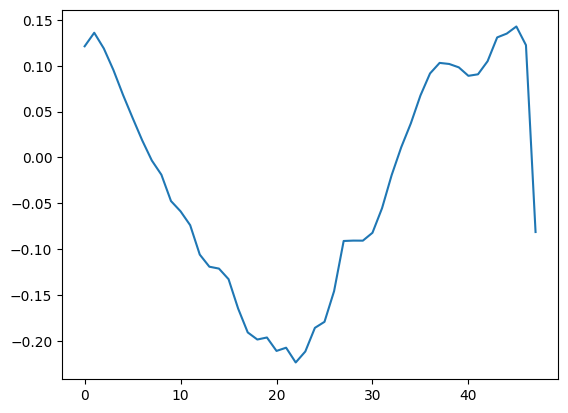

In [149]:
plt.plot(predxcurve[:, -1])


In [ ]:
plt.plot(predxcurve[:, -1])
plt.show()
for token in range(4, activations.shape[2]):
    plt.plot(predxcurve[:, token])
    plt.show()

#this is with the full curve context, and not normalized. looks like there might be a pattern

PearsonRResult(statistic=0.060017467165502575, pvalue=0.6853171799633042)


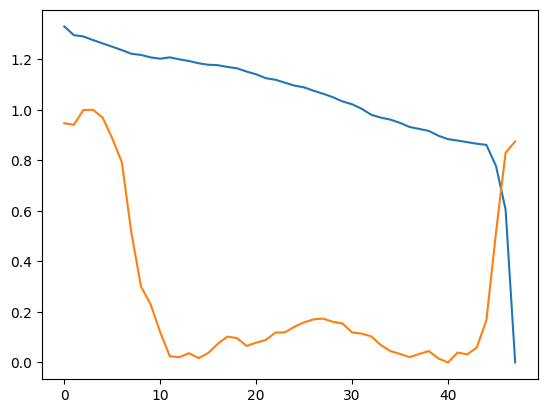

PearsonRResult(statistic=0.20176998623583536, pvalue=0.16905493640294159)


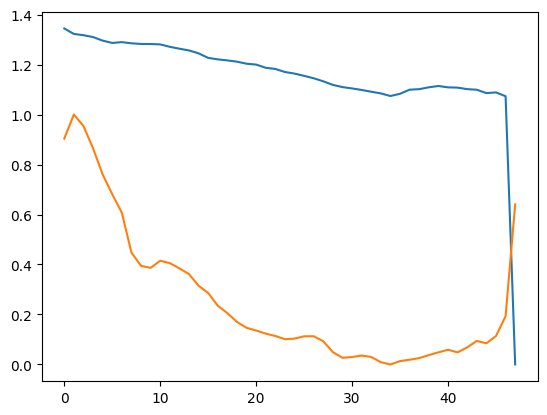

PearsonRResult(statistic=0.2543203927552029, pvalue=0.08109876812186347)


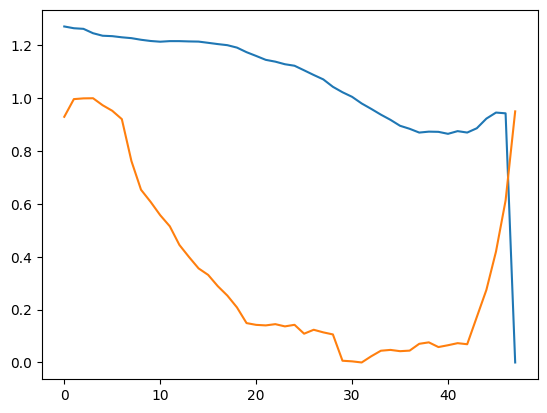

PearsonRResult(statistic=-0.6561743961308346, pvalue=4.122259390072674e-07)


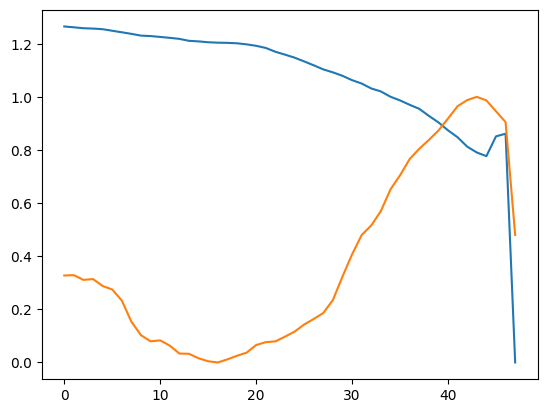

PearsonRResult(statistic=0.5830392490270293, pvalue=1.3704888216366207e-05)


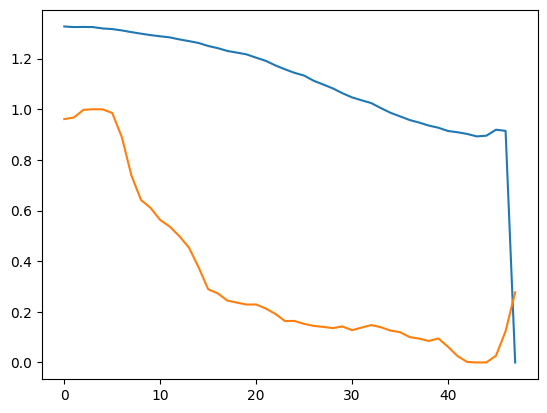

PearsonRResult(statistic=0.2728792488335222, pvalue=0.06058456969707351)


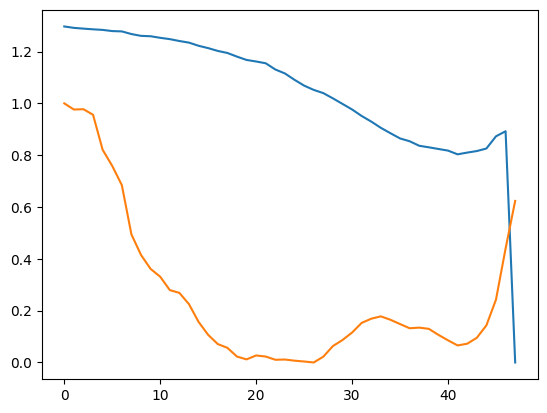

PearsonRResult(statistic=-0.4383543388161475, pvalue=0.001831209147060758)


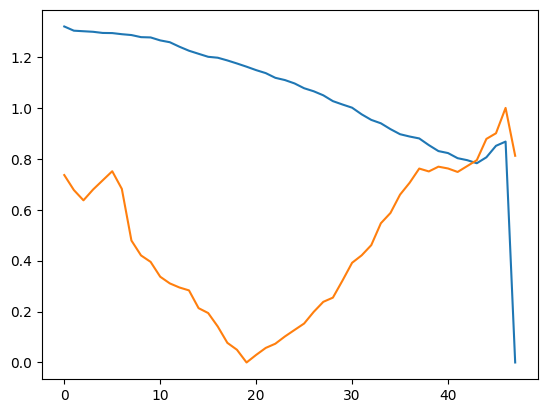

PearsonRResult(statistic=0.35893923566704744, pvalue=0.012232660736124895)


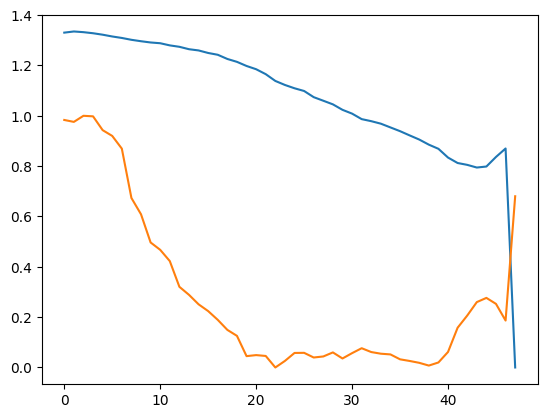

PearsonRResult(statistic=0.20544871053375474, pvalue=0.1612544297703311)


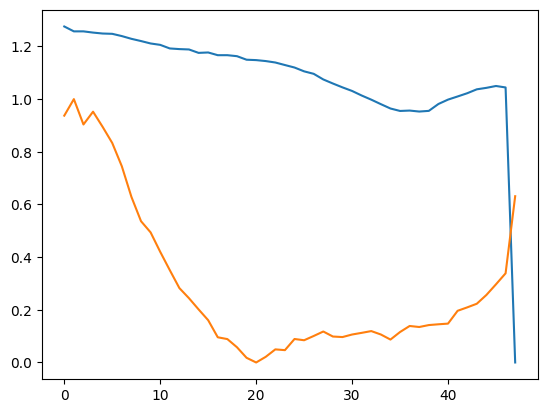

PearsonRResult(statistic=-0.046843101735216025, pvalue=0.7518830438470541)


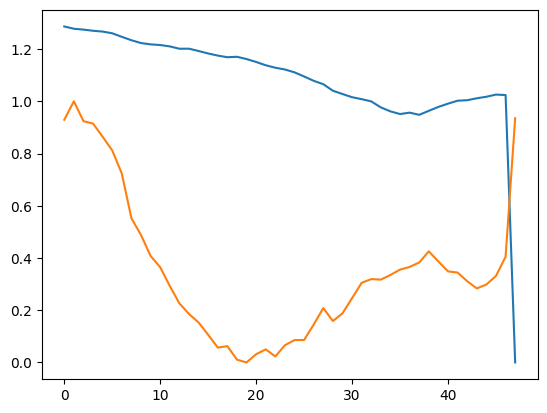

correlation between slope of distance to final and index of min curvature
PearsonRResult(statistic=0.24462162008639426, pvalue=0.059605556866526785)
correlation between difference in distance to final and curvature
PearsonRResult(statistic=-0.09681423507618148, pvalue=2.59079531317676e-07)


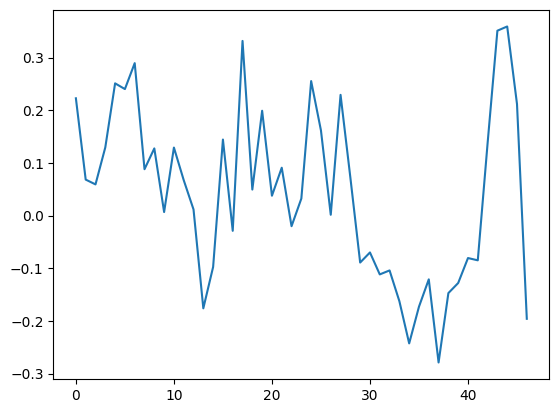

In [135]:
for i in range(10):
    plt.plot(distance_to_final[:, -1, i])
    curvature = np.array(curvatures["curve"])[1:, 240 + i]
    #put curvature between 0 and 1
    curvature = (curvature - curvature.min()) / (curvature.max() - curvature.min())
    corr = stats.pearsonr(curvature, distance_to_final[:, -1, i])
    print(corr)
    plt.plot(curvature)
    plt.show()

# #correlate slope and index of min curvature
curvature = np.array(curvatures["curve"])[1:-1, 240:300]
min_curve_indexes = np.argmin(curvature, axis=0)
random_indexes = np.random.choice(np.arange(20, 45), 10)
lines = distance_to_final[:-10, -1, :] #dont want the weird stuff at the end
slope = np.polyfit(np.arange(lines.shape[0]), lines, 1)[0]
corr = stats.pearsonr(slope, min_curve_indexes)
print("correlation between slope of distance to final and index of min curvature")
print(corr)

#nice, correlation above random. pretty cool...

#correlate difference between distances with curvature
diff = np.diff(distance_to_final[:, -1, :], axis=0)
diff = diff.flatten()
curvature = np.array(curvatures["curve"])[2:, 240:300]
curvature = curvature.flatten()
corr = stats.pearsonr(diff, curvature)
print("correlation between difference in distance to final and curvature")
print(corr)

#correlation just above random...

#same but by layer
correlations = []
diff = np.diff(distance_to_final[:, -1, :], axis=0)
for layer in range(47):
    diff_layer = diff[layer]
    diff_layer = diff_layer.flatten()
    curvature = np.array(curvatures["curve"])[layer+2, 240:300]
    curvature = curvature.flatten()
    corr = stats.pearsonr(diff_layer, curvature)
    correlations.append(corr[0])
plt.plot(correlations)

#same pattern as above...?

(47, 60)
(47, 60)


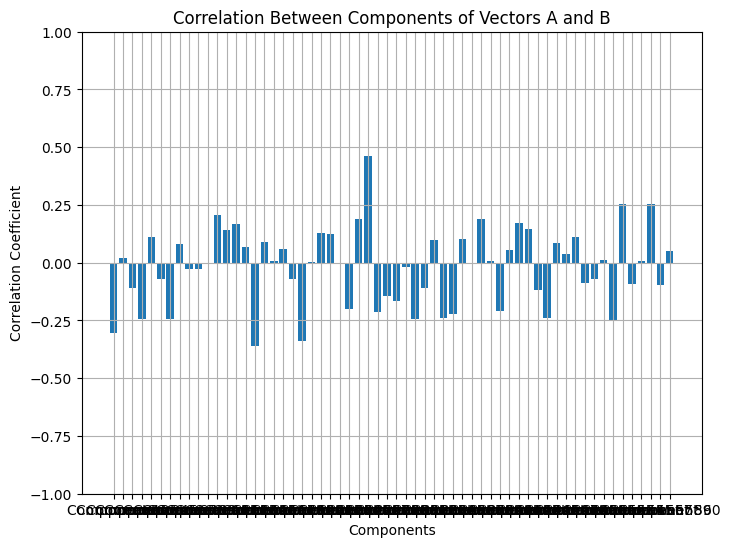

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example data: 100 samples, 5 components
A = distance_to_final[:, -1, :]
#get change in distance
A = np.diff(A, axis=0)
print(A.shape)
B = np.array(curvatures["curve"])[1:-1, 240:300]
print(B.shape)

# Calculate the correlation between corresponding components
correlations = [np.corrcoef(A[:, i], B[:, i])[0, 1] for i in range(A.shape[1])]

# Plotting the correlations
plt.figure(figsize=(8, 6))
plt.bar(range(len(correlations)), correlations)
plt.xticks(range(len(correlations)), [f'Component {i+1}' for i in range(len(correlations))])
plt.xlabel('Components')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Between Components of Vectors A and B')
plt.ylim(-1, 1)  # Correlation ranges from -1 to 1
plt.grid(True)

# Show the plot
plt.show()
